In [1]:
# import libraries
%matplotlib inline
import numpy as np
#import csv
import matplotlib.pyplot as plt
import pandas as pd
import glob
import ulmo
import os
import scipy.spatial

In [2]:
ghcn = pd.read_fwf('data/ghcnd-stations.txt', colspecs = [(0,11), (12,19), (21,29), (31,36),(38,40), (41,70), (72,74),(76,78),(80,85)], header = None) 
colnames = ['GHCN ID', 'lat', 'lon', 'elevation', 'state', 'name', 'gsn flag', 'HCN/CRN FLAG', 'WMO ID']
ghcn.columns = colnames

# append the brightness index 
BI = np.load('data/brightnessGHCN.npy')
ghcn['Brightness'] = BI
# from http://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt
# FORMAT OF "ghcnd-stations.txt"
#
# ------------------------------
# Variable   Columns   Type
# ------------------------------
# ID            1-11   Character
# LATITUDE     13-20   Real
# LONGITUDE    22-30   Real
# ELEVATION    32-37   Real
# STATE        39-40   Character
# NAME         42-71   Character
# GSN FLAG     73-75   Character
# HCN/CRN FLAG 77-79   Character
# WMO ID       81-85   Character
# ------------------------------

# These variables have the following definitions:

# ID         is the station identification code.  Note that the first two
#            characters denote the FIPS  country code, the third character 
#            is a network code that identifies the station numbering system 
#            used, and the remaining eight characters contain the actual 
#            station ID. 

#            See "ghcnd-countries.txt" for a complete list of country codes.
# 	   See "ghcnd-states.txt" for a list of state/province/territory codes.

#            The network code  has the following five values:

#            0 = unspecified (station identified by up to eight 
# 	       alphanumeric characters)
# 	   1 = Community Collaborative Rain, Hail,and Snow (CoCoRaHS)
# 	       based identification number.  To ensure consistency with
# 	       with GHCN Daily, all numbers in the original CoCoRaHS IDs
# 	       have been left-filled to make them all four digits long. 
# 	       In addition, the characters "-" and "_" have been removed 
# 	       to ensure that the IDs do not exceed 11 characters when 
# 	       preceded by "US1". For example, the CoCoRaHS ID 
# 	       "AZ-MR-156" becomes "US1AZMR0156" in GHCN-Daily
#            C = U.S. Cooperative Network identification number (last six 
#                characters of the GHCN-Daily ID)
# 	   E = Identification number used in the ECA&D non-blended
# 	       dataset
# 	   M = World Meteorological Organization ID (last five
# 	       characters of the GHCN-Daily ID)
# 	   N = Identification number used in data supplied by a 
# 	       National Meteorological or Hydrological Center
# 	   R = U.S. Interagency Remote Automatic Weather Station (RAWS)
# 	       identifier
# 	   S = U.S. Natural Resources Conservation Service SNOwpack
# 	       TELemtry (SNOTEL) station identifier
#            W = WBAN identification number (last five characters of the 
#                GHCN-Daily ID)

# LATITUDE   is latitude of the station (in decimal degrees).

# LONGITUDE  is the longitude of the station (in decimal degrees).

# ELEVATION  is the elevation of the station (in meters, missing = -999.9).


# STATE      is the U.S. postal code for the state (for U.S. stations only).

# NAME       is the name of the station.

# GSN FLAG   is a flag that indicates whether the station is part of the GCOS
#            Surface Network (GSN). The flag is assigned by cross-referencing 
#            the number in the WMOID field with the official list of GSN 
#            stations. There are two possible values:

#            Blank = non-GSN station or WMO Station number not available
#            GSN   = GSN station 

# HCN/      is a flag that indicates whether the station is part of the U.S.
# CRN FLAG  Historical Climatology Network (HCN).  There are three possible 
#           values:

#            Blank = Not a member of the U.S. Historical Climatology 
# 	           or U.S. Climate Reference Networks
#            HCN   = U.S. Historical Climatology Network station
# 	   CRN   = U.S. Climate Reference Network or U.S. Regional Climate 
# 	           Network Station

# WMO ID     is the World Meteorological Organization (WMO) number for the
#            station.  If the station has no WMO number (or one has not yet 
# 	   been matched to this station), then the field is blank.

# --------------------------------------------------------------------------------
# --------------------------------------------------------------------------------
giss = pd.read_fwf('data/v3.temperature.inv.txt',skiprows = 39, header = None,
                  colspecs=[(0,3),(3,8),(8,11), (12,44),(44,49), (52,58), (58,63), (63,67), (67,68), (69,73), (73,75), (75, 77), (78,79), (79,81), (81,82),(82,84), (84,100), (100,102), (103,106)])
colnames = ['icc country code', 'WMO ID', '3 digit modifier', 'name','lat', 'lon', 'elevation', 'TELe', 'P', 'Pop', 'Tp', 'V', 'Lo', 'Co', 'Airport', 'ds', 'Vege', 'bi', 'BI']
giss.columns = colnames

# LEGEND  
# ======
# icc  =3 digit country code; the first digit represents WMO region/continent
# WMO_#=5 digit WMO station number
# ...  =3 digit modifier; 000 means the station is probably the WMO
#       station; 001, etc. mean the station is near that WMO station
# Name =30 character station name
# Lat  =latitude in degrees, negative = South of Equator
# Lon  =longitude in degrees, negative = West of Greenwich (England)
# Elev =station elevation in meters, missing is -999
# TEle =station elevation interpolated from TerrainBase gridded data set
# P    =R if rural (not associated with a town of >10,000 population)
#       S if associated with a small town (10,000-50,000 population)
#       U if associated with an urban area (>50,000 population)
# Pop  =population of the small town or urban area in 1000s
#       If rural, no analysis:  -9.
# Tp   =general topography around the station:  FL flat; HI hilly,
#       MT mountain top; MV mountainous valley or at least not on the top
#       of a mountain.
# V    =general vegetation near the station based on Operational
#       Navigation Charts;  MA marsh; FO forested; IC ice; DE desert;
#       CL clear or open;  xx information not provided
# Lo   =CO if station is within 30 km from the coast
#       LA if station is next to a large (> 25 km**2) lake
#       no if neither of the above
#       Note: Stations which are both CO and LA will be marked CO
# Co   =distance in km to the coast if Lo=CO, else -9
# A    =A if the station is at an airport; else x
# ds   =distance in km from the airport to its associated
#       small town or urban center (not relevant for rural airports
#       or non airport stations in which case ds=-9)
# Vege =gridded vegetation for the 0.5x0.5 degree grid point closest
#       to the station from a gridded vegetation data base. 16 characters.
# bi   =brightness index    A=dark B=dim C=bright   (comment added by R.Ruedy)
# BI   =brightness index    0=dark -> 256 =bright   (based on satellite night light data)

see: http://stackoverflow.com/questions/35296935/python-calculate-lots-of-distances-quickly

In [134]:
asos = pd.read_fwf('asos-stations.txt').drop(0)

In [136]:
asos.head()

,NCDCID,WBAN,COOPID,CALL,NAME,ALT_NAME,COUNTRY,ST,COUNTY,LAT,LON,ELEV,UTC,STNTYPE
1,20028647,15908,NaN,YRL,RED LAKE,RED LAKE,CANADA,ON,NaN,51.06667,-93.8,1230,-6,ASOS
2,20030346,41415,914226,GUM,GUAM INTL AP,GUAM NWSO TIYAN,GUAM,GU,GUAM,13.48333,144.8,254,10,"ASOS,COOP,WXSVC"
3,20030369,41418,914855,GSN,SAIPAN INTL AP,SAIPAN INTL AP,NORTHERN MARIANA ISL,MP,SAIPAN,15.11667,145.71667,215,10,"ASOS,COOP"
4,20023988,11641,668812,SJU,SAN JUAN L M MARIN AP,SAN JUAN INTL AP,PUERTO RICO,PR,NaN,18.4325,-66.01083,9,-4,"ASOS,COOP"
5,20022052,26409,NaN,MRI,ANCHORAGE MERRILL FLD,ANCHORAGE MERRILL FLD,UNITED STATES,AK,ANCHORAGE BOROUGH,61.21694,-149.855,138,-9,"AIRWAYS,ASOS"


In [164]:
asos[asos['COUNTRY'].str.contains('UNITED STATES')].shape

(915, 14)

In [155]:
asos[asos.ST.str.contains('MD')]

,NCDCID,WBAN,COOPID,CALL,NAME,ALT_NAME,COUNTRY,ST,COUNTY,LAT,LON,ELEV,UTC,STNTYPE
402,20009551,93721,180465,BWI,BALTIMORE-WASHINGTON INTL AP,BALTIMORE-WASHINGTON INTL AP,UNITED STATES,MD,ANNE ARUNDEL,39.1666,-76.6833,156,-5,"ASOS,COOP"
403,20009660,93706,NaN,HGR,HAGERSTOWN WASHINGTON CO AP,HAGERSTOWN WASHINGTON CO AP,UNITED STATES,MD,WASHINGTON,39.70778,-77.72972,698,-5,"AIRWAYS,ASOS"
404,30000697,93784,185718,DMH,MARYLAND SCI CTR,MARYLAND SCI CTR,UNITED STATES,MD,BALTIMORE (CITY),39.2814,-76.6089,20,-5,"ASOS,COOP,USHCN"
405,30000851,93786,NaN,OXB,OCEAN CITY MUNI AP,OCEAN CITY MUNI AP,UNITED STATES,MD,WORCESTER,38.30833,-75.12389,-99999,-5,"AIRWAYS,ASOS"
406,20009433,93720,188005,SBY,SALISBURY WICOMICO RGNL AP,SALISBURY FAA AP,UNITED STATES,MD,WICOMICO,38.34056,-75.51028,48,-5,"AIRWAYS,ASOS,COOP"


In [159]:
ghcn[ghcn.name.str.contains('HAGERSTOWN')]

,GHCN ID,lat,lon,elevation,state,name,gsn flag,HCN/CRN FLAG,WMO ID,Brightness
58707,US1MDWH0003,39.642,-77.701,160.0,MD,HAGERSTOWN 1.0 ENE,NaN,NaN,NaN,62.0
80792,USC00183975,39.650,-77.733,201.0,MD,HAGERSTOWN,NaN,NaN,NaN,63.0
80793,USC00183980,39.604,-77.732,170.0,MD,HAGERSTOWN POLICE BRK,NaN,NaN,NaN,57.0
99682,USW00093706,39.707,-77.729,212.0,MD,HAGERSTOWN WASHINGTON CO AP,NaN,NaN,NaN,60.0


In [140]:
asos[asos.NAME.str.contains('MARYLAND')]

,NCDCID,WBAN,COOPID,CALL,NAME,ALT_NAME,COUNTRY,ST,COUNTY,LAT,LON,ELEV,UTC,STNTYPE
404,30000697,93784,185718,DMH,MARYLAND SCI CTR,MARYLAND SCI CTR,UNITED STATES,MD,BALTIMORE (CITY),39.2814,-76.6089,20,-5,"ASOS,COOP,USHCN"


In [144]:
ghcn.head()

,GHCN ID,lat,lon,elevation,state,name,gsn flag,HCN/CRN FLAG,WMO ID,Brightness
0,ACW00011604,17.116,-61.783,10.0,NaN,ST JOHNS COOLIDGE FLD,NaN,NaN,NaN,36.0
1,ACW00011647,17.133,-61.783,19.0,NaN,ST JOHNS,NaN,NaN,NaN,37.0
2,AE000041196,25.333,55.517,34.0,NaN,SHARJAH INTER. AIRP,GS,NaN,41196.0,63.0
3,AEM00041194,25.255,55.364,10.0,NaN,DUBAI INTL,NaN,NaN,41194.0,63.0
4,AEM00041217,24.433,54.651,26.0,NaN,ABU DHABI INTL,NaN,NaN,41217.0,63.0


In [152]:
asos.set_index('NAME', drop = False).loc[ghcn.set_index('GHCN ID').loc[paired_stations['Urban station']].name]['STNTYPE']

NAME
HARTFORD BRAINARD FLD                                   ASOS
PROVIDENCE T F GREEN AP                                  NaN
BIRMINGHAM AP                    AIRSAMPLE,AIRWAYS,ASOS,COOP
TAMPA INTL AP                                      ASOS,COOP
OAKLAND MUSEUM                                           NaN
WEST PALM BEACH INTL AP                   ASOS,COOP,UPPERAIR
LOUISVILLE INTL AP                           ASOS,COOP,WXSVC
CHARLOTTE DOUGLAS AP                               ASOS,COOP
COLUMBUS PORT COLUMBUS INTL A                            NaN
TUCSON INTL AP                                     ASOS,COOP
FRESNO YOSEMITE INTL AP                                  NaN
ALBUQUERQUE INTL AP              AIRSAMPLE,AIRWAYS,ASOS,COOP
KANSAS CITY DOWNTOWN AP                    AIRWAYS,ASOS,COOP
TULSA INTL AP                            AIRSAMPLE,ASOS,COOP
AUSTIN-CAMP MABRY                                  ASOS,COOP
EL PASO INTL AP                              ASOS,COOP,USHCN
ORLANDO INTL AP    

In [105]:
paired_stations.set_index?

In [108]:
drop_cities = ['Mesa','Long Beach', 'Grand Prairie', 'Virginia Beach', 'St. Paul' ]
paired_stations = pd.read_csv('NovUSpairs_stationlengths_stationavailability75.csv').set_index('City', drop=False).drop(drop_cities)

In [109]:
paired_stations.head()

,Unnamed: 0,City,Urban station,Urban Lat,Urban Lon,Urban brightness,Urban start,Urban end,Rural station,Rural Lat,Rural Lon,Rural brightness,Rural start,Rural end
City,,,,,,,,,,,,,,
Hartford,11,Hartford,USW00014752,41.736,-72.650,62.0,1920-01-01,2016-09-30,USC00065445,41.972,-73.220,7.0,1884-11-01 00:00:00,2016-10-31
Providence,12,Providence,USW00014765,41.721,-71.432,62.0,1948-01-01,2016-09-30,USC00375270,41.856,-71.733,12.0,1974-10-01,2016-07-31
Birmingham,13,Birmingham,USW00013876,33.565,-86.745,63.0,1930-01-01,2016-09-30,USC00010505,33.452,-87.357,7.0,1957-02-01,2016-07-31
St. Petersburg,14,St. Petersburg,USW00012842,27.961,-82.540,63.0,1939-02-01,2016-09-30,USC00086065,27.241,-82.316,7.0,1956-02-01,2016-08-31
Oakland,16,Oakland,USC00046336,37.798,-122.264,63.0,1970-10-01,2016-10-31,USC00045915,37.879,-121.930,9.0,1952-04-01,2016-09-30


In [161]:
paired_stations['Urban station']

City
Hartford            USW00014752
Providence          USW00014765
Birmingham          USW00013876
St. Petersburg      USW00012842
Oakland             USC00046336
West Palm Beach     USW00012844
Louisville          USW00093821
Charlotte           USW00013881
Columbus            USW00014821
Tucson              USW00023160
Fresno              USW00093193
Albuquerque         USW00023050
Kansas City         USW00013988
Tulsa               USW00013968
Austin              USW00013958
El Paso             USW00023044
Orlando             USW00012815
Jacksonville        USC00084366
Indianapolis        USW00093819
Richmond            USC00444101
Baltimore           USW00093721
San Jose            USW00023244
Sacramento          USW00023271
Las Vegas           USW00023169
Portland            USW00024229
Salt Lake City      USW00024127
Omaha               USW00014942
Oklahoma City       USW00013967
San Antonio         USW00012921
Raleigh             USC00317079
Cleveland           USW00014820
Cin

In [162]:
paired_stations['Rural station']

City
Hartford            USC00065445
Providence          USC00375270
Birmingham          USC00010505
St. Petersburg      USC00086065
Oakland             USC00045915
West Palm Beach     USC00081276
Louisville          USC00150630
Charlotte           USC00314996
Columbus            USC00331404
Tucson              USC00020287
Fresno              USC00040379
Albuquerque         USC00299820
Kansas City         USC00143686
Tulsa               USC00347390
Austin              USC00413686
El Paso             USC00294426
Orlando             USC00081641
Jacksonville        USC00082915
Indianapolis        USC00128784
Richmond            USC00448829
Baltimore           USC00182060
San Jose            USC00045933
Sacramento          USC00043384
Las Vegas           USC00262243
Portland            USS0023D02S
Salt Lake City      USC00425892
Omaha               USC00255362
Oklahoma City       USC00345779
San Antonio         USC00417215
Raleigh             USC00317656
Cleveland           USC00333780
Cin

In [94]:
# Urban stations that are neither GHCN stations nor WMO
#ghcn.set_index('GHCN ID').loc[coop_city_stations.index]
city_stations = ghcn.set_index('GHCN ID').loc[stations['Urban station']][['HCN/CRN FLAG', 'WMO ID']]
coop_city_stations = city_stations[(np.isnan(city_stations['WMO ID'])) & (city_stations['HCN/CRN FLAG'] != 'HC') & (city_stations['HCN/CRN FLAG'] != 'CR')]
ghcn.set_index('GHCN ID').loc[coop_city_stations.index]

,lat,lon,elevation,state,name,gsn flag,HCN/CRN FLAG,WMO ID,Brightness
GHCN ID,,,,,,,,,
USW00014752,41.736,-72.650,5.0,CT,HARTFORD BRAINARD FLD,NaN,NaN,NaN,62.0
USC00046336,37.798,-122.264,9.0,CA,OAKLAND MUSEUM,NaN,NaN,NaN,63.0
USW00013988,39.120,-94.596,226.0,MO,KANSAS CITY DOWNTOWN AP,NaN,NaN,NaN,63.0
USC00084366,30.287,-81.392,3.0,FL,JACKSONVILLE BEACH,NaN,NaN,NaN,61.0
USW00023271,38.555,-121.416,11.0,CA,SACRAMENTO 5 ESE,NaN,NaN,NaN,63.0
USC00317079,35.794,-78.698,121.0,NC,RALEIGH STATE UNIV,NaN,NaN,NaN,63.0
USW00093812,39.103,-84.418,149.0,OH,CINCINNATI LUNKEN AP,NaN,NaN,NaN,62.0
USW00013750,36.950,-76.283,5.0,VA,NORFOLK NAS,NaN,NaN,NaN,63.0
USC00519397,21.271,-157.816,3.0,HI,WAIKIKI 717.2,NaN,NaN,NaN,62.0


In [160]:
coop_city_stations

,HCN/CRN FLAG,WMO ID
GHCN ID,,
USW00014752,NaN,NaN
USC00046336,NaN,NaN
USW00013988,NaN,NaN
USC00084366,NaN,NaN
USW00023271,NaN,NaN
USC00317079,NaN,NaN
USW00093812,NaN,NaN
USW00013750,NaN,NaN
USC00519397,NaN,NaN


In [113]:
noGHCNstations_urban= paired_stations.set_index('Urban station').loc[coop_city_stations.index].City

In [122]:
noGHCNstations_urban.values

array(['Hartford', 'Oakland', 'Kansas City', 'Jacksonville', 'Sacramento',
       'Raleigh', 'Cincinnati', 'Norfolk', 'Honolulu', 'Seattle',
       'St. Louis', 'Miami', 'Los Angeles', 'Washington, D.C.'], dtype=object)

In [114]:
noGHCNstations_urban.shape

(14,)

In [95]:
rural_stations = ghcn.set_index('GHCN ID').loc[stations['Rural station']][['HCN/CRN FLAG', 'WMO ID']]
coop_rural_stations = rural_stations[(np.isnan(rural_stations['WMO ID'])) & (rural_stations['HCN/CRN FLAG'] != 'HC') & (rural_stations['HCN/CRN FLAG'] != 'CR')]
ghcn.set_index('GHCN ID').loc[coop_rural_stations.index]

,lat,lon,elevation,state,name,gsn flag,HCN/CRN FLAG,WMO ID,Brightness
GHCN ID,,,,,,,,,
USC00065445,41.972,-73.220,408.0,CT,NORFOLK 2 SW,NaN,NaN,NaN,7.0
USC00375270,41.856,-71.733,192.0,RI,NORTH FOSTER 1 E,NaN,NaN,NaN,12.0
USC00010505,33.452,-87.357,85.0,AL,BANKHEAD L&D,NaN,NaN,NaN,7.0
USC00086065,27.241,-82.316,6.0,FL,MYAKKA RIVER SP,NaN,NaN,NaN,7.0
USC00045915,37.879,-121.930,661.0,CA,MT DIABLO JUNCTION,NaN,NaN,NaN,9.0
USC00081276,26.863,-80.625,9.0,FL,CANAL POINT USDA,NaN,NaN,NaN,14.0
USC00150630,37.916,-85.657,167.0,KY,BERNHEIM FOREST,NaN,NaN,NaN,11.0
USC00314996,35.460,-81.328,274.0,NC,LINCOLNTON 4 W,NaN,NaN,NaN,13.0
USC00331404,40.291,-82.654,367.0,OH,CENTERBURG 2 SE,NaN,NaN,NaN,10.0


In [116]:
noGHCNstations_rural= paired_stations.set_index('Rural station').loc[coop_rural_stations.index].City
noGHCNstations_rural

Rural station
USC00065445            Hartford
USC00375270          Providence
USC00010505          Birmingham
USC00086065      St. Petersburg
USC00086065               Tampa
USC00045915             Oakland
USC00081276     West Palm Beach
USC00150630          Louisville
USC00314996           Charlotte
USC00331404            Columbus
USC00020287              Tucson
USC00040379              Fresno
USC00299820         Albuquerque
USC00143686         Kansas City
USC00347390               Tulsa
USC00413686              Austin
USC00081641             Orlando
USC00128784        Indianapolis
USC00448829            Richmond
USC00182060           Baltimore
USC00045933            San Jose
USC00043384          Sacramento
USC00262243           Las Vegas
USS0023D02S            Portland
USC00425892      Salt Lake City
USC00255362               Omaha
USC00417215         San Antonio
USC00317656             Raleigh
USC00339361          Cincinnati
USC00401663           Nashville
USC00033821             Me

In [117]:
noGHCNstations_rural.shape

(48,)

In [118]:
paired_stations.shape

(53, 14)

In [120]:
np.intersect1d(noGHCNstations_urban, noGHCNstations_rural)

array(['Cincinnati', 'Hartford', 'Kansas City', 'Los Angeles', 'Miami',
       'Norfolk', 'Oakland', 'Raleigh', 'Sacramento', 'Seattle',
       'St. Louis', 'Washington, D.C.'], dtype=object)

In [123]:
np.intersect1d(noGHCNstations_urban, noGHCNstations_rural).shape

(12,)

In [3]:
# subset the GHCN station list with the list of available stations
currentstations = ulmo.ncdc.ghcn_daily.get_stations(start_year=1985, end_year = 2016, elements = ['TMIN', 'TMAX', 'AWND'], as_dataframe=True, update=False)
currentGHCNstations = np.intersect1d(currentstations.id, ghcn.index.values) #ghcn['GHCN ID'].values)
ghcnSubset = ghcn.set_index('GHCN ID').loc[currentstations.id.values]

# at this point, ghcn must have the station id set as the index 

In [4]:
ghcn = ghcn.set_index('GHCN ID').loc[currentstations.id.values]

In [5]:
# compute distances between all stations
#tree = scipy.spatial.cKDTree(giss[['lon', 'lat']].values, leafsize=100)
# query the closest point 
#closestInd = tree.query(giss[['lon', 'lat']].values[11,:], k =2, distance_upper_bound=6)[1][1]

In [26]:
atlas = pd.read_csv('data/sampleAtlas.csv') # derived  from http://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-populated-places/
atlas = pd.read_csv('data/world_cities.csv')
tree = scipy.spatial.cKDTree(ghcn[['lon', 'lat']].values, leafsize=100)
#import sys
#sys.path.append('/../cityheat/Bmore/2015/')
#sys.path.append('/Users/annascott2/mountpoint/cityheat/Bmore/2015/')
#import spatialfunctions
atlas = atlas[atlas['pop']> 500000]

In [27]:
#atlas = pd.read_csv('data/world_cities.csv')

In [28]:
atlas = atlas[atlas['country'].str.contains('United States')] # do non-US countries

In [29]:
#atlas = atlas[atlas['country'].str.contains('United States')].set_index('city')

In [184]:
brightness_threshold = 25 # this is the urban/rural threshold delimiter, difference between urban and rural
#outFile = 'worldghcnpairs_stationlengths.csv'
outFile = 'NovUSpairs_stationlengths_stationavailability75.csv'
pairs = []
frames = []
startdate = np.datetime64('1985-06-01')
enddate = np.datetime64('2015-08-30')

In [230]:
atlas

,city,city_ascii,lat,lng,pop,country,iso2,iso3,province
6321,Mesa,Mesa,33.423915,-111.736084,762217.5,United States of America,US,USA,Arizona
6393,Arlington,Grand Prairie,32.684761,-97.020238,545107.5,United States of America,US,USA,Texas
6571,Irvine,Irvine,33.680411,-117.829950,1611303.5,United States of America,US,USA,California
6689,New Haven,New Haven,41.330383,-72.900005,707883.0,United States of America,US,USA,Connecticut
6707,Fort Lauderdale,Fort Lauderdale,26.136065,-80.141786,1103781.5,United States of America,US,USA,Florida
6847,Long Beach,Long Beach,33.786967,-118.158044,1249195.5,United States of America,US,USA,California
6870,Hartford,Hartford,41.770020,-72.679967,518509.5,United States of America,US,USA,Connecticut
6871,Providence,Providence,41.821102,-71.414980,663726.5,United States of America,US,USA,Rhode Island
6872,Birmingham,Birmingham,33.530006,-86.824995,670142.0,United States of America,US,USA,Alabama
6875,St. Petersburg,St. Petersburg,27.770539,-82.679383,523314.5,United States of America,US,USA,Florida


In [222]:
#for i in range(793, atlas.shape[0]): 
data_availability_thresh = .75
for i in range(17, atlas.shape[0]):
    lat = atlas.iloc[i]['lat']
    lon = atlas.iloc[i]['lng']
    city = atlas.iloc[i]['city_ascii']
    print(city)
    closeststations = tree.query([lon,lat], k =15, distance_upper_bound=1)

    # Make sure the closest stations are within a finite distance
    closestInds = closeststations[1][~np.isinf(closeststations[0])]
    # make sure that there are stations 
    if closestInds.shape[0] > 0 : 
        urban = ghcn.Brightness[closestInds].argmax()
        rural = ghcn.Brightness[closestInds].argmin()
        #         if urban != rural: 
        urban_data = ulmo.ncdc.ghcn_daily.get_data(urban, as_dataframe=True, update=False)
        rural_data = ulmo.ncdc.ghcn_daily.get_data(rural, as_dataframe=True, update=False)

        number_urban_stations = (ghcn.Brightness[closestInds] >= brightness_threshold).sum() # number of urban stations is equivalent to brightness over 30
        number_rural_stations = (ghcn.Brightness[closestInds] < brightness_threshold).sum() # number of rural stations is equivalent to brightness over 30
        delta_brightness = 30
        break_value = -1

        iii = 1
#        while ('TMAX' not in urban_data.keys() or 'TMIN' not in urban_data.keys()) or (urban_data['TMAX'].index[0].to_timestamp().to_datetime() > startdate) or (urban_data['TMAX'].index[-1].to_timestamp().to_datetime() < enddate) : 
        while ('TMAX' not in urban_data.keys()) or ('TMIN' not in urban_data.keys()) or (urban_data['TMAX'].index[0].to_timestamp() > startdate) or (urban_data['TMAX'].index[-1].to_timestamp() < enddate) or ((~np.isnan(urban_data['TMIN'].set_index(urban_data['TMIN'].index.to_timestamp())['1985-06-01':'2015-08-31'].value.values.astype(float))).sum()/(365*30.+90.) < data_availability_thresh) : 
        # check if there's enough suitable urban stations to check the next one, ignoring the current one 
            if iii > number_urban_stations-1 : 
                print('no suitable urban station for %s'%city) 
                urban = break_value
                break 
            # find the next brightestcity
            print 'finding the next urban station for %s'%city
            urban = ghcn.Brightness[closestInds][(-ghcn.Brightness[closestInds].values).argsort()].index[iii]
            urban_data = ulmo.ncdc.ghcn_daily.get_data(urban, as_dataframe=True, update=False)
            #print urban, urban_data['TMIN'].index[0], urban_data['TMIN'].index[-1], ghcn.Brightness[urban], urban_data.keys(), (~np.isnan(urban_data['TMIN'].set_index(urban_data['TMIN'].index.to_timestamp())['1985-06-01':'2015-08-31'].value.values.astype(float))).sum()/(365.*30.+90.)
            iii = iii+1    

        # if no urban station found, don't bother to pair with rural 
        if urban != break_value : 
            # check rural data station different from urban has TMIN, TMAX, a long enough record, and is rural enough compared to urban (delta_brightness)
            iii = 1
            enlarge_circle = 0 # number of times we can try increasing search radius
            while (urban ==rural) or ('TMAX' not in rural_data.keys() and 'TMIN' not in rural_data.keys()) or (rural_data['TMIN'].index[0].to_timestamp() > startdate) or (rural_data['TMIN'].index[-1].to_timestamp() < enddate) or (ghcn.Brightness[urban]-ghcn.Brightness[rural]<delta_brightness) or ((~np.isnan(rural_data['TMIN'].set_index(rural_data['TMIN'].index.to_timestamp())['1985-06-01':'2015-08-31'].value.values.astype(float))).sum()/(365*30.+90) < data_availability_thresh): 
                print 'finding the next rural station for %s'%city

                # if we can't find any suitable stations, try enlarging the search radius, but only try this once
                if iii > number_rural_stations-1 : 
                    if enlarge_circle > 0 : 
                        rural = break_value
                        break #break when we've already used up all the search
                    else: 
                        # find 25 closest stations within 1.5 degree circle
                        closeststations1 = tree.query([lon,lat], k =35, distance_upper_bound=1.5 ) 
                        # eliminate the ones we've already search 
                        new_stations = np.setdiff1d(closeststations1[1], closeststations[1])
                        # Make sure that we've actually found new stations, otherwise break
                        if new_stations.shape[0] >0 : 
                            # Make sure the closest stations are within a finite distance
                            closestInds1 = closeststations1[1][~np.isinf(closeststations1[0])]
                            # Eliminate repeat stations
                            closestInds = np.intersect1d(new_stations, closestInds1)
                            # reset counter, number of rural stations
                            iii = 0
                            number_rural_stations = (ghcn.Brightness[closestInds] < brightness_threshold).sum()
                        else: 
                            rural = break_value
                            break
                        # reset list of rural stations
                    print 'increasing search radius'
                    enlarge_circle = enlarge_circle+1
                    
                # find the next dimmest
                rural = ghcn.Brightness[closestInds][(ghcn.Brightness[closestInds].values).argsort()].index[iii]
                rural_data = ulmo.ncdc.ghcn_daily.get_data(rural, as_dataframe=True, update=False)
                print rural, rural_data['TMIN'].index[0], rural_data['TMIN'].index[-1], ghcn.Brightness[rural], rural_data.keys(), (~np.isnan(rural_data['TMIN'].set_index(rural_data['TMIN'].index.to_timestamp())['1985-06-01':'2015-08-31'].value.values.astype(float))).sum()/(365*30.+90)
                iii = iii+1
        else: 
            rural = break_value
    # else condition for not being any stations
    else: 
        urban = break_value 
        rural = break_value
            
    # save out if we've found a good pairing
    if (urban != break_value) and (rural != break_value) : 
        print('Found a pair for %s'%city)
        print('Urban start/end is: %s to %s'%(urban_data['TMAX'].index[0].to_timestamp().to_datetime(),  urban_data['TMAX'].index[-1].to_timestamp().to_datetime()))
        print('Rural start/end is: %s to %s'%(rural_data['TMAX'].index[0].to_timestamp().to_datetime(),  rural_data['TMAX'].index[-1].to_timestamp().to_datetime()))
        frames.append([city, urban, #['GHCN ID'],
                       ghcn.loc[urban].lat, 
                       ghcn.loc[urban].lon, 
                       ghcn.loc[urban].Brightness,
                       urban_data['TMAX'].index[0].to_timestamp().to_datetime(), urban_data['TMAX'].index[-1].to_timestamp().to_datetime(), 
                       rural, #['GHCN ID'],
                       ghcn.loc[rural].lat, 
                       ghcn.loc[rural].lon, 
                       ghcn.loc[rural].Brightness, 
                        rural_data['TMAX'].index[0].to_timestamp().to_datetime(), rural_data['TMAX'].index[-1].to_timestamp().to_datetime(),])
    else : 
        print 'No pair found for %s'%city
        frames.append([city, np.nan, #['GHCN ID'],
                       np.nan,
                       np.nan,
                       np.nan, 
                       np.nan, #['GHCN ID'],
                       np.nan,
                       np.nan,
                       np.nan, np.nan, np.nan, np.nan, np.nan])

    # periodiically save out results
    if i%50 ==0: 
        pairs = pd.DataFrame(frames, columns = ['City', 'Urban station', 
                                          'Urban Lat', 'Urban Lon','Urban brightness', 'Urban start', 'Urban end',
                                          'Rural station', 
                                          'Rural Lat', 'Rural Lon','Rural brightness', 'Rural start', 'Rural end'])

        pairs.to_csv(outFile)
        
# pairs = pd.DataFrame(frames, columns = ['City', 'Urban station', 
#                                   'Urban Lat', 'Urban Lon','Urban brightness', 
#                                   'Rural station', 
#                                   'Rural Lat', 'Rural Lon','Rural brightness'])

pairs = pd.DataFrame(frames, columns = ['City', 'Urban station', 
                                          'Urban Lat', 'Urban Lon','Urban brightness', 'Urban start', 'Urban end',
                                          'Rural station', 
                                          'Rural Lat', 'Rural Lon','Rural brightness', 'Rural start', 'Rural end'])

pairs.to_csv(outFile)
pairs[(~np.isnan(pairs['Urban Lat'])) & (pairs['Rural start']<startdate)].to_csv(outFile)

Bridgeport
finding the next urban station for Bridgeport
finding the next urban station for Bridgeport
finding the next urban station for Bridgeport
finding the next urban station for Bridgeport
finding the next rural station for Bridgeport
increasing search radius
USC00060961 1957-05-01 1999-11-30 9.0 ['WT06', 'TMIN', 'TOBS', 'TMAX', 'SNOW', 'DAPR', 'SNWD', 'WT11', 'WT05', 'WT04', 'PRCP', 'WT01', 'MDPR', 'WT03'] 0.468387681159
finding the next rural station for Bridgeport
USC00067373 1949-03-01 2003-01-31 10.0 ['WT06', 'TMIN', 'TOBS', 'TMAX', 'MDSF', 'SNOW', 'DAPR', 'WT03', 'SNWD', 'WT05', 'WT04', 'PRCP', 'WT01', 'MDPR', 'DASF'] 0.486956521739
finding the next rural station for Bridgeport
USC00069568 1949-06-01 1997-01-31 20.0 ['WT06', 'TMIN', 'WT14', 'TOBS', 'TMAX', 'MDSF', 'SNOW', 'DAPR', 'WT03', 'SNWD', 'WT11', 'WT05', 'WT04', 'PRCP', 'WT01', 'MDPR', 'DASF', 'WT08'] 0.361322463768
finding the next rural station for Bridgeport
No pair found for Bridgeport
St. Paul
finding the next u

In [223]:
i

69

In [229]:
outFile

'NovUSpairs_stationlengths_stationavailability75.csv'

In [225]:
pairs[(~np.isnan(pairs['Urban Lat'])) & (pairs['Rural start']<startdate)].to_csv(outFile)

In [227]:
pairs = pairs[(~np.isnan(pairs['Urban Lat'])) & (pairs['Rural start']<startdate)]

In [228]:
pairs

,City,Urban station,Urban Lat,Urban Lon,Urban brightness,Urban start,Urban end,Rural station,Rural Lat,Rural Lon,Rural brightness,Rural start,Rural end
1,Mesa,USC00028499,33.425,-111.921,63.0,1953-01-01,2016-07-31,USC00028214,33.557,-111.535,7.0,1961-04-01,2016-09-30
2,Grand Prairie,USW00003927,32.897,-97.018,63.0,1948-01-01,2016-10-31,USC00410518,32.263,-96.636,9.0,1965-04-01,2016-10-31
6,Grand Prairie,USW00003927,32.897,-97.018,63.0,1948-01-01,2016-10-31,USC00410518,32.263,-96.636,9.0,1965-04-01,2016-10-31
10,Long Beach,USW00023129,33.811,-118.146,63.0,1949-01-01,2016-09-30,USC00046006,34.230,-118.071,14.0,1948-07-01,2016-08-31
11,Hartford,USW00014752,41.736,-72.650,62.0,1920-01-01,2016-09-30,USC00065445,41.972,-73.220,7.0,1884-11-01 00:00:00,2016-10-31
12,Providence,USW00014765,41.721,-71.432,62.0,1948-01-01,2016-09-30,USC00375270,41.856,-71.733,12.0,1974-10-01,2016-07-31
13,Birmingham,USW00013876,33.565,-86.745,63.0,1930-01-01,2016-09-30,USC00010505,33.452,-87.357,7.0,1957-02-01,2016-07-31
14,St. Petersburg,USW00012842,27.961,-82.540,63.0,1939-02-01,2016-09-30,USC00086065,27.241,-82.316,7.0,1956-02-01,2016-08-31
15,Virginia Beach,USW00013769,36.816,-76.033,63.0,1945-03-01,2016-09-30,USC00440385,36.661,-75.911,5.0,1953-12-01,2016-09-30
16,Oakland,USC00046336,37.798,-122.264,63.0,1970-10-01,2016-10-31,USC00045915,37.879,-121.930,9.0,1952-04-01,2016-09-30


In [208]:
rural = 'USR0000CTAN'
#         if urban != rural: 
rural_data = ulmo.ncdc.ghcn_daily.get_data(rural, as_dataframe=True, update=False)


In [210]:
('TMAX' not in rural_data.keys() and 'TMIN' not in rural_data.keys()) or (rural_data['TMIN'].index[0].to_timestamp() > startdate) or (rural_data['TMIN'].index[-1].to_timestamp() < enddate) or (ghcn.Brightness[urban]-ghcn.Brightness[rural]<delta_brightness) or ((~np.isnan(rural_data['TMIN'].set_index(rural_data['TMIN'].index.to_timestamp())['1985-06-01':'2015-08-31'].value.values.astype(float))).sum()/(365*30.+90) < data_availability_thresh)


True

In [211]:
rural_data.keys()

['TAVG', 'TMAX', 'TMIN']

In [212]:
rural_data['TMIN'].index[0].to_timestamp() > startdate

True

In [213]:
rural_data['TMIN'].index[0].to_timestamp() 

Timestamp('1986-02-01 00:00:00')

In [220]:
pairs = pd.DataFrame(frames, columns = ['City', 'Urban station', 
                                          'Urban Lat', 'Urban Lon','Urban brightness', 'Urban start', 'Urban end',
                                          'Rural station', 
                                          'Rural Lat', 'Rural Lon','Rural brightness', 'Rural start', 'Rural end'])
pairs[(~np.isnan(pairs['Urban Lat'])) & (pairs['Rural start']<startdate)]

,City,Urban station,Urban Lat,Urban Lon,Urban brightness,Urban start,Urban end,Rural station,Rural Lat,Rural Lon,Rural brightness,Rural start,Rural end
1,Mesa,USC00028499,33.425,-111.921,63.0,1953-01-01,2016-07-31,USC00028214,33.557,-111.535,7.0,1961-04-01,2016-09-30
2,Grand Prairie,USW00003927,32.897,-97.018,63.0,1948-01-01,2016-10-31,USC00410518,32.263,-96.636,9.0,1965-04-01,2016-10-31
6,Grand Prairie,USW00003927,32.897,-97.018,63.0,1948-01-01,2016-10-31,USC00410518,32.263,-96.636,9.0,1965-04-01,2016-10-31
10,Long Beach,USW00023129,33.811,-118.146,63.0,1949-01-01,2016-09-30,USC00046006,34.230,-118.071,14.0,1948-07-01,2016-08-31
11,Hartford,USW00014752,41.736,-72.650,62.0,1920-01-01,2016-09-30,USC00065445,41.972,-73.220,7.0,1884-11-01 00:00:00,2016-10-31
12,Providence,USW00014765,41.721,-71.432,62.0,1948-01-01,2016-09-30,USC00375270,41.856,-71.733,12.0,1974-10-01,2016-07-31
13,Birmingham,USW00013876,33.565,-86.745,63.0,1930-01-01,2016-09-30,USC00010505,33.452,-87.357,7.0,1957-02-01,2016-07-31
14,St. Petersburg,USW00012842,27.961,-82.540,63.0,1939-02-01,2016-09-30,USC00086065,27.241,-82.316,7.0,1956-02-01,2016-08-31
15,Virginia Beach,USW00013769,36.816,-76.033,63.0,1945-03-01,2016-09-30,USC00440385,36.661,-75.911,5.0,1953-12-01,2016-09-30
16,Oakland,USC00046336,37.798,-122.264,63.0,1970-10-01,2016-10-31,USC00045915,37.879,-121.930,9.0,1952-04-01,2016-09-30


In [183]:
pairs[~np.isnan(pairs['Urban Lat'])].shape

(10, 13)

In [178]:
pairs

,City,Urban station,Urban Lat,Urban Lon,Urban brightness,Urban start,Urban end,Rural station,Rural Lat,Rural Lon,Rural brightness,Rural start,Rural end
0,Mesa,USC00028499,33.425,-111.921,63.0,1953-01-01,2016-07-31,USC00028214,33.557,-111.535,7.0,1961-04-01,2016-09-30
1,Grand Prairie,USW00003927,32.897,-97.018,63.0,1948-01-01,2016-10-31,USC00410518,32.263,-96.636,9.0,1965-04-01,2016-10-31
2,Irvine,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaT
3,New Haven,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaT
4,Fort Lauderdale,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaT
5,Long Beach,USW00023129,33.811,-118.146,63.0,1949-01-01,2016-09-30,USW00023191,33.405,-118.415,4.0,1948-01-01,2016-09-30
6,Hartford,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaT
7,Providence,USW00014765,41.721,-71.432,62.0,1948-01-01,2016-09-30,USC00375270,41.856,-71.733,12.0,1974-10-01,2016-07-31
8,Birmingham,USW00013876,33.565,-86.745,63.0,1930-01-01,2016-09-30,USC00010505,33.452,-87.357,7.0,1957-02-01,2016-07-31
9,St. Petersburg,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaT


In [125]:
city

'New York'

In [91]:
atlas.shape

(70, 9)

In [153]:
urban_data['TMIN'].set_index(urban_data['TMIN'].index.to_timestamp())['1985-06-01':'2015-08-31'].value.astype(float).values

array([ 183.,  167.,  200., ...,  194.,  222.,  244.])

In [154]:
np.isnan(urban_data['TMIN'].set_index(urban_data['TMIN'].index.to_timestamp())['1985-06-01':'2015-08-31'].value.astype(float).values).sum()

0

In [157]:
(~np.isnan(urban_data['TMIN'].set_index(urban_data['TMIN'].index.to_timestamp())['1985-06-01':'2015-08-31'].value.values.astype(float))).sum()

11049

In [158]:
urban_data_availability = (~np.isnan(urban_data['TMIN'].set_index(urban_data['TMIN'].index.to_timestamp())['1985-06-01':'2015-08-31'].value.values.astype(float))).sum()/(365*30.)
urban_data_availability

1.009041095890411

In [159]:
rural_data_availability = (~np.isnan(rural_data['TMIN'].set_index(rural_data['TMIN'].index.to_timestamp())['1985-06-01':'2015-08-31'].value.values.astype(float))).sum()/(365*30.)
rural_data_availability

0.10557077625570777

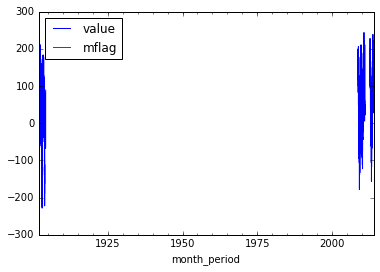

In [161]:
rural_data['TMIN'].plot()

In [ ]:
# check cities: albuquerque, arlington, bridgeport, detroit, ft. lauderdale, ft. worth,
# long beach, milwaukee, new haven, new orleans, oakland, orlando, pittsburg, richmond,
# san bernadino, san francisco, seattle, st. paul, 

In [124]:
pairs[(~np.isnan(pairs['Urban Lat'])) & (pairs['Rural start']<startdate)]

,City,Urban station,Urban Lat,Urban Lon,Urban brightness,Urban start,Urban end,Rural station,Rural Lat,Rural Lon,Rural brightness,Rural start,Rural end
0,Mesa,USC00028499,33.425,-111.921,63.0,1953-01-01,2016-07-31,USC00028214,33.557,-111.535,7.0,1961-04-01,2016-09-30
5,Grand Prairie,USC00410337,32.757,-97.073,63.0,1893-01-01 00:00:00,2016-09-30,USC00410518,32.263,-96.636,9.0,1965-04-01,2016-10-31
9,Long Beach,USW00023129,33.811,-118.146,63.0,1949-01-01,2016-09-30,USW00023191,33.405,-118.415,4.0,1948-01-01,2016-09-30
10,Hartford,USW00014752,41.736,-72.650,62.0,1920-01-01,2016-09-30,USC00065445,41.972,-73.220,7.0,1884-11-01 00:00:00,2016-10-31
11,Providence,USW00014765,41.721,-71.432,62.0,1948-01-01,2016-09-30,USC00375270,41.856,-71.733,12.0,1974-10-01,2016-07-31
12,Birmingham,USW00013876,33.565,-86.745,63.0,1930-01-01,2016-09-30,USC00010505,33.452,-87.357,7.0,1957-02-01,2016-07-31
13,St. Petersburg,USW00012842,27.961,-82.540,63.0,1939-02-01,2016-09-30,USC00086065,27.241,-82.316,7.0,1956-02-01,2016-08-31
14,Virginia Beach,USW00013769,36.816,-76.033,63.0,1945-03-01,2016-09-30,USC00440385,36.661,-75.911,5.0,1953-12-01,2016-09-30
15,Oakland,USW00023230,37.721,-122.220,63.0,1948-01-01,2016-09-30,USC00045915,37.879,-121.930,9.0,1952-04-01,2016-09-30
16,West Palm Beach,USW00012844,26.684,-80.099,63.0,1938-07-01,2016-09-30,USC00081276,26.863,-80.625,14.0,1953-01-01,2016-10-31


In [119]:
pairs[pairs['Urban start'] > startdate]

,City,Urban station,Urban Lat,Urban Lon,Urban brightness,Urban start,Urban end,Rural station,Rural Lat,Rural Lon,Rural brightness,Rural start,Rural end


In [120]:
pairs[pairs['Rural start'] > startdate]

,City,Urban station,Urban Lat,Urban Lon,Urban brightness,Urban start,Urban end,Rural station,Rural Lat,Rural Lon,Rural brightness,Rural start,Rural end
1,Grand Prairie,USC00410337,32.757,-97.073,63.0,1893-01-01 00:00:00,2016-09-30,USR0000TLBJ,33.172,-97.375,8.0,2000-01-01,2016-09-30
2,Irvine,USC00047888,33.744,-117.866,63.0,1916-05-01,2016-09-30,USC00047836,33.531,-117.552,11.0,2001-10-01,2015-08-31
3,New Haven,USC00065077,41.407,-72.903,60.0,1936-02-01,2016-03-31,USC00060808,41.120,-73.080,7.0,2008-03-01,2016-09-30
4,Grand Prairie,USC00410337,32.757,-97.073,63.0,1893-01-01 00:00:00,2016-09-30,USR0000TLBJ,33.172,-97.375,8.0,2000-01-01,2016-09-30


In [123]:
pairs

,City,Urban station,Urban Lat,Urban Lon,Urban brightness,Urban start,Urban end,Rural station,Rural Lat,Rural Lon,Rural brightness,Rural start,Rural end
0,Mesa,USC00028499,33.425,-111.921,63.0,1953-01-01,2016-07-31,USC00028214,33.557,-111.535,7.0,1961-04-01,2016-09-30
1,Grand Prairie,USC00410337,32.757,-97.073,63.0,1893-01-01 00:00:00,2016-09-30,USR0000TLBJ,33.172,-97.375,8.0,2000-01-01,2016-09-30
2,Irvine,USC00047888,33.744,-117.866,63.0,1916-05-01,2016-09-30,USC00047836,33.531,-117.552,11.0,2001-10-01,2015-08-31
3,New Haven,USC00065077,41.407,-72.903,60.0,1936-02-01,2016-03-31,USC00060808,41.120,-73.080,7.0,2008-03-01,2016-09-30
4,Grand Prairie,USC00410337,32.757,-97.073,63.0,1893-01-01 00:00:00,2016-09-30,USR0000TLBJ,33.172,-97.375,8.0,2000-01-01,2016-09-30
5,Grand Prairie,USC00410337,32.757,-97.073,63.0,1893-01-01 00:00:00,2016-09-30,USC00410518,32.263,-96.636,9.0,1965-04-01,2016-10-31
6,Irvine,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaT
7,New Haven,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaT
8,Fort Lauderdale,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaT
9,Long Beach,USW00023129,33.811,-118.146,63.0,1949-01-01,2016-09-30,USW00023191,33.405,-118.415,4.0,1948-01-01,2016-09-30


In [121]:
pairs[pairs['Urban end'] < enddate]

,City,Urban station,Urban Lat,Urban Lon,Urban brightness,Urban start,Urban end,Rural station,Rural Lat,Rural Lon,Rural brightness,Rural start,Rural end


In [122]:
pairs[pairs['Rural end'] < enddate]

,City,Urban station,Urban Lat,Urban Lon,Urban brightness,Urban start,Urban end,Rural station,Rural Lat,Rural Lon,Rural brightness,Rural start,Rural end


In [115]:
pairs[(~np.isnan(pairs['Urban Lat'])) & (pairs['Rural start']<startdate)].to_csv('CleanedNovUSpairs_stationlengths.csv')

In [581]:
good_results[good_results['Urban station'].str.contains('US')]

,Unnamed: 0,City,Urban station,Urban Lat,Urban Lon,Urban brightness,Rural station,Rural Lat,Rural Lon,Rural brightness
886,886,Arlington,USC00410337,32.757,-97.073,63.0,USC00413133,32.533,-96.660,46.0
890,890,Long Beach,USW00023129,33.811,-118.146,63.0,USC00046175,33.602,-117.880,60.0
917,917,Mesa,USC00028499,33.425,-111.921,63.0,USC00028214,33.557,-111.535,7.0
918,918,Arlington,USC00410337,32.757,-97.073,63.0,USR0000TLBJ,33.172,-97.375,8.0
919,919,Irvine,USC00047888,33.744,-117.866,63.0,USC00047836,33.531,-117.552,11.0
920,920,New Haven,USC00065077,41.407,-72.903,60.0,USC00060808,41.120,-73.080,7.0
921,921,Fort Lauderdale,USC00083168,26.140,-80.106,63.0,USC00088368,26.470,-80.640,4.0
922,922,Long Beach,USW00023129,33.811,-118.146,63.0,USW00023191,33.405,-118.415,4.0
923,923,Hartford,USW00014752,41.736,-72.650,62.0,USC00193167,42.066,-72.900,8.0
924,924,Providence,USW00014765,41.721,-71.432,62.0,USC00375270,41.856,-71.733,12.0


In [18]:
# # calculate the brightness index for all stations
# from osgeo import ogr, osr
# import os
# from shapely.geometry import Point
# import shapely.geometry
# import shapely.wkt
# from cartopy.feature import ShapelyFeature
# from cartopy.io.shapereader import Reader
# import gdal

# # rasterfile = 'data/F182013.v4/F182013.v4c_web.stable_lights.avg_vis.tif'
# # layer = gdal.Open(rasterfile)
# # gt =layer.GetGeoTransform()
# # bands = layer.RasterCount
# # src = layer.GetRasterBand(1)
# X = ghcnSubset['lon']
# Y = ghcnSubset['lat']

In [19]:
# #rasterfile = 'data/F182013.v4/F182013.v4c_web.stable_lights.avg_vis.tif'
# rasterfile = 'data/F182013.v4/F182013.v4c_web.avg_vis.tif'
# layer = gdal.Open(rasterfile)
# gt =layer.GetGeoTransform()
# bands = layer.RasterCount
# src = layer.GetRasterBand(1)

# BI = np.zeros(X.shape)
# i = 0 
# for x,y in zip(X,Y): 
#     rasterx = int((x - gt[0]) / gt[1])
#     rastery = int((y - gt[3]) / gt[5])
#     BI[i] = src.ReadAsArray(rasterx,rastery, win_xsize=1, win_ysize=1)
#     i = i+1

# #np.save('brightnessGHCNsubset.npy', BI)
# #BI = np.load('data/brightnessGHCN.npy')

AttributeError: 'NoneType' object has no attribute 'GetGeoTransform'